In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogFormatter
import pickle
import os
import numpy as np

## Xeon Platinum 8175M Single Core Peak GFLOP/s

In [32]:
AVX512_FLOPS_PER_CYCLE = 8*2 # DP FMA
NUM_AVX512_UNITS = 2
AVX512_FREQ = 2.4 # All Cores Active AVX512 Boost (GHz)
XEON_8175M_PEAK_FLOPS = AVX512_FREQ * NUM_AVX512_UNITS * AVX512_FLOPS_PER_CYCLE

In [33]:
XEON_8175M_PEAK_FLOPS

76.8

## Xeon Platinum 8175M Single Core Tuned STREAM BW

In [34]:
XEON_8175M_PEAK_BW = 13.5163 # GB/s

## Load FLOP/s of benchmark

In [35]:
from calc_pseudo import clean, basic_flops
B_TARGET_PANEL_WIDTH = 48
MAT_PATH = "./../../../synth_mats/"
mat_paths = sum([[os.path.join(dir, file) for file in files] for dir, _, files in os.walk(MAT_PATH)], [])
mat_FLOPS = {}
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    
    mat_FLOPS[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL

In [36]:
LOG_DIR = "./../../../logs/regpack_ln2/synth/"
LOG_DIR2 = "./../../../logs/regpack_ln3/synth/"
with open(LOG_DIR+"run_1.dat", "rb") as f:
    run_1 = pickle.load(f)
with open(LOG_DIR+"run_2.dat", "rb") as f:
    run_2 = pickle.load(f)
with open(LOG_DIR+"run_3.dat", "rb") as f:
    run_3 = pickle.load(f)

with open(LOG_DIR2+"run_1.dat", "rb") as f:
    ln3_run_1 = pickle.load(f)
with open(LOG_DIR2+"run_2.dat", "rb") as f:
    ln3_run_2 = pickle.load(f)
with open(LOG_DIR2+"run_3.dat", "rb") as f:
    ln3_run_3 = pickle.load(f)

In [37]:
def calc_GFLOPs(mat_FLOPS, runs, t='best'):
    NUM_PANELS = 192000 / 48

    mat_names = runs[0]['mat_file']
    local_FLOPs = []
    ref_FLOPs = []

    for i, mat_name in enumerate(mat_names):
        FLOPS_PER_PANEL = mat_FLOPS[mat_name]
        local_best = []
        ref_best = []
        for r, run in enumerate(runs):
            time_per_panel_local = (run['xsmm_local_'+t][i]*1e-3)/NUM_PANELS
            time_per_panel_ref   = (run['xsmm_upstream_'+t][i]*1e-3)/NUM_PANELS

            local_best.append(FLOPS_PER_PANEL / time_per_panel_local)
            ref_best.append(FLOPS_PER_PANEL / time_per_panel_ref)
        local_avg = sum(local_best) / len(local_best)
        ref_avg = sum(ref_best) / len(ref_best)

        local_FLOPs.append(local_avg / 1e9)
        ref_FLOPs.append(ref_avg / 1e9)

    return mat_names, ref_FLOPs, local_FLOPs

## Load AI of benchmark

In [38]:
import math

def calc_mem_ref_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        has_A = False
        for el in col:
            if el != 0:
                has_A = True
        # at least one A - load stride of B into cache
        if has_A:
            mem += 8*8

    # store C
    for row in mat:
        has_A = False
        for el in row:
            if el != 0:
                has_A = True
        # at least one A - store a C stride
        if has_A:
            mem += 8*8

    return (mem * num_panels)# + mem_A # dont repeat A load

def calc_mem_ref_dense_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        mem += 8*8

    # store C
    for row in mat:
        mem += 8*8

    return (mem * num_panels)# + mem_A # dont repeat A load

def calc_mem_local_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        has_A = False
        for el in col:
            if el != 0:
                has_A = True
        # at least one A - load stride of B into cache
        if has_A:
            mem += 8*8

    # store C
    for row in mat:
        has_A = False
        for el in row:
            if el != 0:
                has_A = True
        # at least one A - store a C stride
        if has_A:
            mem += 8*8

    # round A up to nearest multiple of 64 (cache line)
    # mem_A = int(math.ceil(mem_A / 64.0)) * 64
    return (mem * num_panels)# + mem_A # dont repeat A load

In [39]:
mat_AI_ref = {}
mat_AI_ref_dense = {}
mat_AI_local = {}
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    REF_MEM_PER_PANEL = calc_mem_ref_beta_0(test_mat)
    REF_DENSE_MEM_PER_PANEL = calc_mem_ref_dense_beta_0(test_mat)
    LOCAL_MEM_PER_PANEL = calc_mem_local_beta_0(test_mat)

    mat_AI_ref[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL / REF_MEM_PER_PANEL
    mat_AI_ref_dense[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL / REF_DENSE_MEM_PER_PANEL
    mat_AI_local[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL / LOCAL_MEM_PER_PANEL

In [40]:
def get_AI(mat_AI_ref, mat_AI_local, mat_names):
    ref_AIs, local_AIs = [], []
    
    for mat_name in mat_names:
        ref_AIs.append(mat_AI_ref[mat_name])
        local_AIs.append(mat_AI_local[mat_name])
    
    return ref_AIs, local_AIs

In [41]:
types = ["vary_row/q_16", "vary_row/q_64",
	 "vary_col/q_16", "vary_col/q_64",
         "vary_density/q_16", "vary_density/q_64",
         "vary_unique"]

# Vary Row

## Unique 16

In [42]:
vr16_mat_names, vr16_ref_FLOPs, vr16_local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1['vary_row/q_16'], run_2['vary_row/q_16'], run_3['vary_row/q_16']])
_, _, vr16_ln3_FLOPs = calc_GFLOPs(mat_FLOPS, [ln3_run_1['vary_row/q_16'], ln3_run_2['vary_row/q_16'], ln3_run_3['vary_row/q_16']])

In [43]:
vr16_ref_AIs, vr16_local_AIs = get_AI(mat_AI_ref, mat_AI_local, vr16_mat_names)

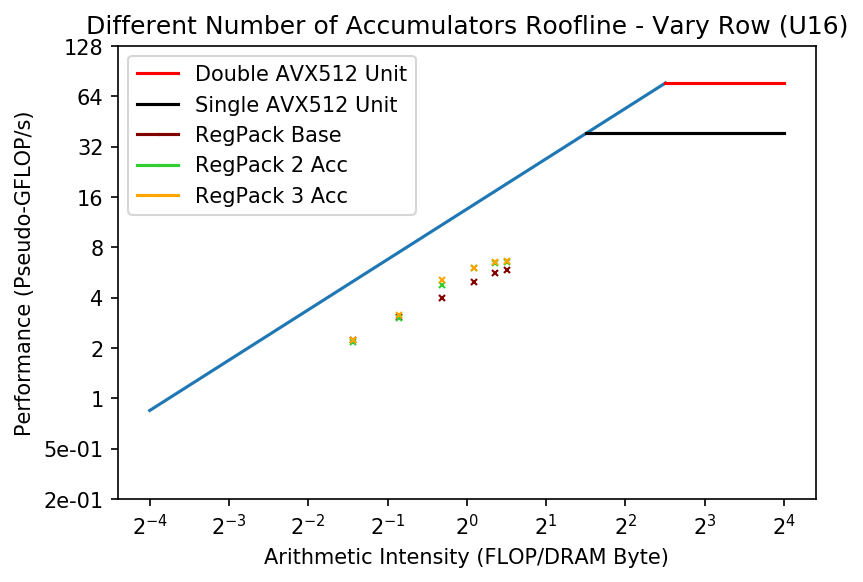

In [44]:
mat_names = vr16_mat_names
ref_AIs = vr16_ref_AIs
ref_FLOPs = vr16_ref_FLOPs
local_AIs = vr16_local_AIs
local_FLOPs = vr16_local_FLOPs

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='black', label="Single AVX512 Unit")

ax.plot(local_AIs[0], ref_FLOPs[0], marker='x', color='maroon', ms=1, label="RegPack Base")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(local_AIs[0], local_FLOPs[0], marker='x', color='limegreen', ms=1, label="RegPack 2 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], local_FLOPs[i], marker='x', color='limegreen', ms=3)
ax.plot(local_AIs[0], vr16_ln3_FLOPs[0], marker='x', color='orange', ms=1, label="RegPack 3 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], vr16_ln3_FLOPs[i], marker='x', color='orange', ms=3)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
ax.set_title('Different Number of Accumulators Roofline - Vary Row (U16)')
plt.legend()
plt.savefig("./../../../plots/regpack_ln2/synth/roofline/vary_row_u16.pdf")
plt.show()

## Unique 64

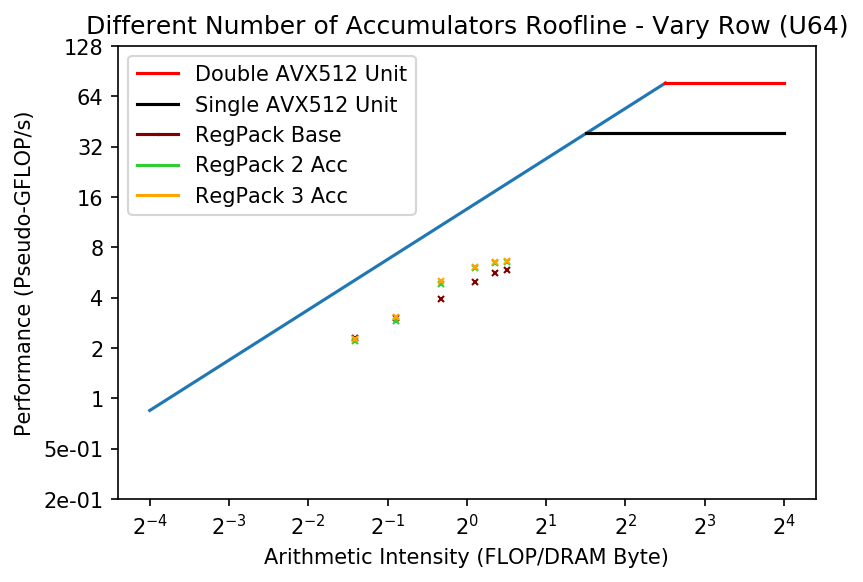

In [45]:
key = 'vary_row/q_64'
mat_names, ref_FLOPs, local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1[key], run_2[key], run_3[key]])
_, _, ln3_FLOPs = calc_GFLOPs(mat_FLOPS, [ln3_run_1[key], ln3_run_2[key], ln3_run_3[key]])
ref_AIs, local_AIs = get_AI(mat_AI_ref_dense, mat_AI_local, mat_names)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='black', label="Single AVX512 Unit")

ax.plot(local_AIs[0], ref_FLOPs[0], marker='x', color='maroon', ms=1, label="RegPack Base")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(local_AIs[0], local_FLOPs[0], marker='x', color='limegreen', ms=1, label="RegPack 2 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], local_FLOPs[i], marker='x', color='limegreen', ms=3)
ax.plot(local_AIs[0], ln3_FLOPs[0], marker='x', color='orange', ms=1, label="RegPack 3 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ln3_FLOPs[i], marker='x', color='orange', ms=3)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
ax.set_title('Different Number of Accumulators Roofline - Vary Row (U64)')
plt.legend()
plt.savefig("./../../../plots/regpack_ln2/synth/roofline/vary_row_u64.pdf")
plt.show()

# Vary Column

## Unique 16

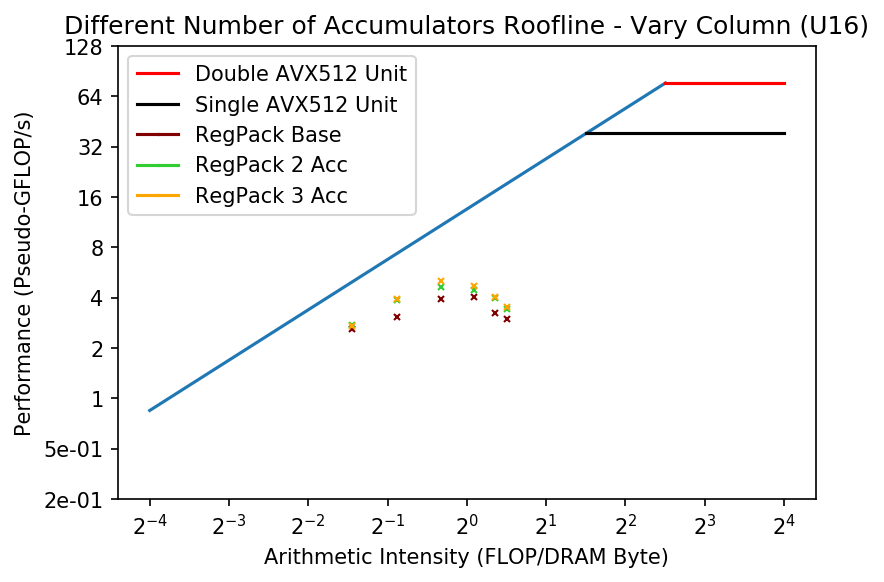

In [46]:
key = 'vary_col/q_16'
mat_names, ref_FLOPs, local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1[key], run_2[key], run_3[key]])
_, _, ln3_FLOPs = calc_GFLOPs(mat_FLOPS, [ln3_run_1[key], ln3_run_2[key], ln3_run_3[key]])
ref_AIs, local_AIs = get_AI(mat_AI_ref, mat_AI_local, mat_names)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='black', label="Single AVX512 Unit")

ax.plot(local_AIs[0], ref_FLOPs[0], marker='x', color='maroon', ms=1, label="RegPack Base")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(local_AIs[0], local_FLOPs[0], marker='x', color='limegreen', ms=1, label="RegPack 2 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], local_FLOPs[i], marker='x', color='limegreen', ms=3)
ax.plot(local_AIs[0], ln3_FLOPs[0], marker='x', color='orange', ms=1, label="RegPack 3 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ln3_FLOPs[i], marker='x', color='orange', ms=3)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
ax.set_title('Different Number of Accumulators Roofline - Vary Column (U16)')
plt.legend()
plt.savefig("./../../../plots/regpack_ln2/synth/roofline/vary_col_u16.pdf")
plt.show()

## Unique 64

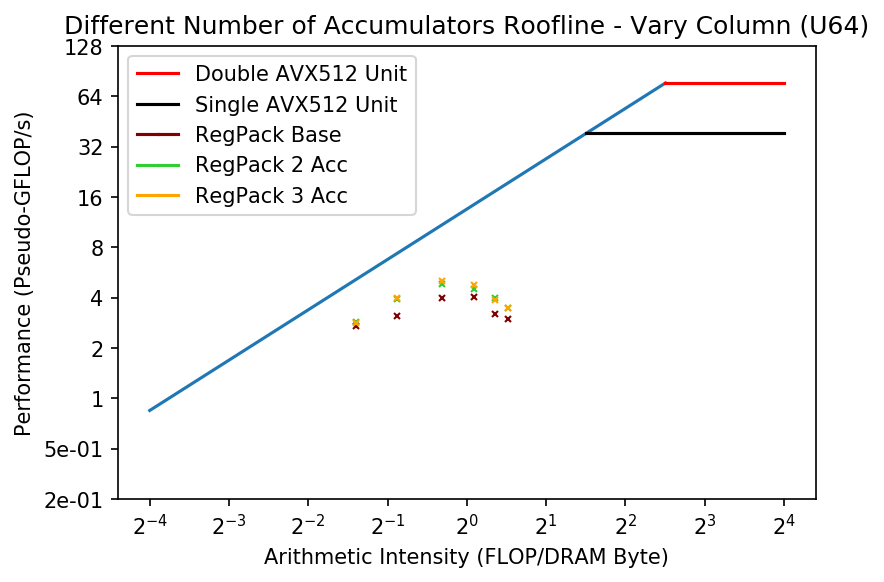

In [47]:
key = 'vary_col/q_64'
mat_names, ref_FLOPs, local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1[key], run_2[key], run_3[key]])
_, _, ln3_FLOPs = calc_GFLOPs(mat_FLOPS, [ln3_run_1[key], ln3_run_2[key], ln3_run_3[key]])
ref_AIs, local_AIs = get_AI(mat_AI_ref_dense, mat_AI_local, mat_names)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='black', label="Single AVX512 Unit")

ax.plot(local_AIs[0], ref_FLOPs[0], marker='x', color='maroon', ms=1, label="RegPack Base")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(local_AIs[0], local_FLOPs[0], marker='x', color='limegreen', ms=1, label="RegPack 2 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], local_FLOPs[i], marker='x', color='limegreen', ms=3)
ax.plot(local_AIs[0], ln3_FLOPs[0], marker='x', color='orange', ms=1, label="RegPack 3 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ln3_FLOPs[i], marker='x', color='orange', ms=3)


ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
ax.set_title('Different Number of Accumulators Roofline - Vary Column (U64)')
plt.legend()
plt.savefig("./../../../plots/regpack_ln2/synth/roofline/vary_col_u64.pdf")
plt.show()

# Vary Density

## Unique 16

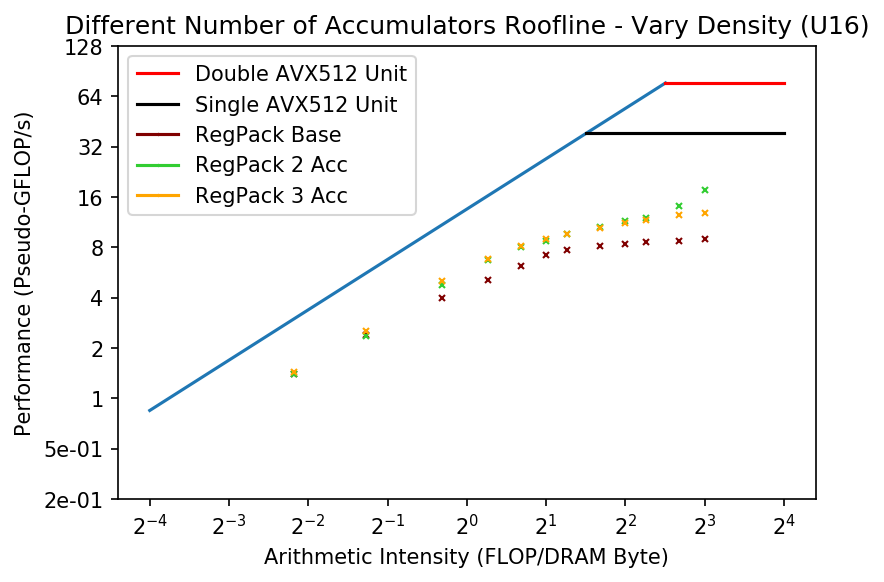

In [48]:
key = 'vary_density/q_16'
mat_names, ref_FLOPs, local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1[key], run_2[key], run_3[key]])
_, _, ln3_FLOPs = calc_GFLOPs(mat_FLOPS, [ln3_run_1[key], ln3_run_2[key], ln3_run_3[key]])
ref_AIs, local_AIs = get_AI(mat_AI_ref, mat_AI_local, mat_names)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='black', label="Single AVX512 Unit")

ax.plot(local_AIs[0], ref_FLOPs[0], marker='x', color='maroon', ms=1, label="RegPack Base")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(local_AIs[0], local_FLOPs[0], marker='x', color='limegreen', ms=1, label="RegPack 2 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], local_FLOPs[i], marker='x', color='limegreen', ms=3)
ax.plot(local_AIs[0], ln3_FLOPs[0], marker='x', color='orange', ms=1, label="RegPack 3 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ln3_FLOPs[i], marker='x', color='orange', ms=3)


ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
ax.set_title('Different Number of Accumulators Roofline - Vary Density (U16)')
plt.legend()
plt.savefig("./../../../plots/regpack_ln2/synth/roofline/vary_density_u16.pdf")
plt.show()

## Unique 64

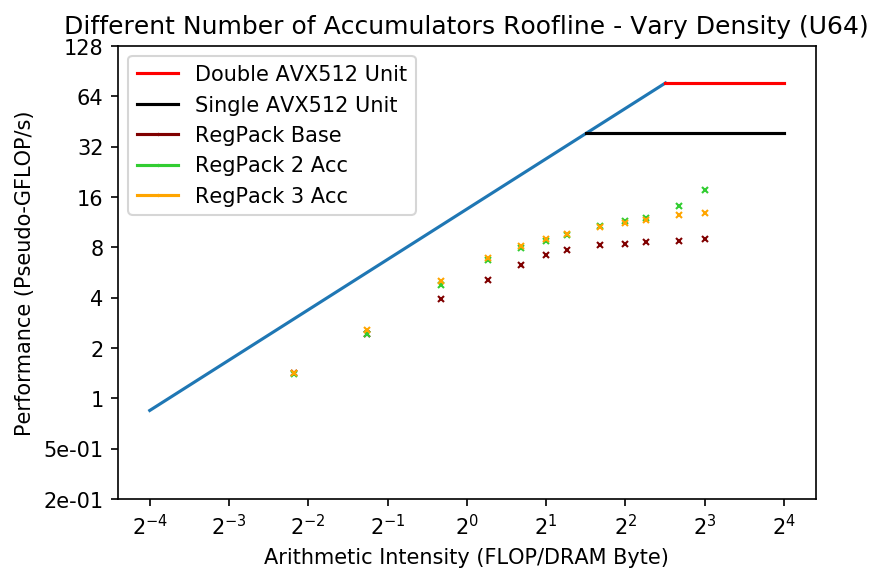

In [49]:
key = 'vary_density/q_64'
mat_names, ref_FLOPs, local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1[key], run_2[key], run_3[key]])
_, _, ln3_FLOPs = calc_GFLOPs(mat_FLOPS, [ln3_run_1[key], ln3_run_2[key], ln3_run_3[key]])
ref_AIs, local_AIs = get_AI(mat_AI_ref_dense, mat_AI_local, mat_names)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='black', label="Single AVX512 Unit")

ax.plot(local_AIs[0], ref_FLOPs[0], marker='x', color='maroon', ms=1, label="RegPack Base")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(local_AIs[0], local_FLOPs[0], marker='x', color='limegreen', ms=1, label="RegPack 2 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], local_FLOPs[i], marker='x', color='limegreen', ms=3)
ax.plot(local_AIs[0], ln3_FLOPs[0], marker='x', color='orange', ms=1, label="RegPack 3 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ln3_FLOPs[i], marker='x', color='orange', ms=3)


ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
ax.set_title('Different Number of Accumulators Roofline - Vary Density (U64)')
plt.legend()
plt.savefig("./../../../plots/regpack_ln2/synth/roofline/vary_density_u64.pdf")
plt.show()

# Vary Unique

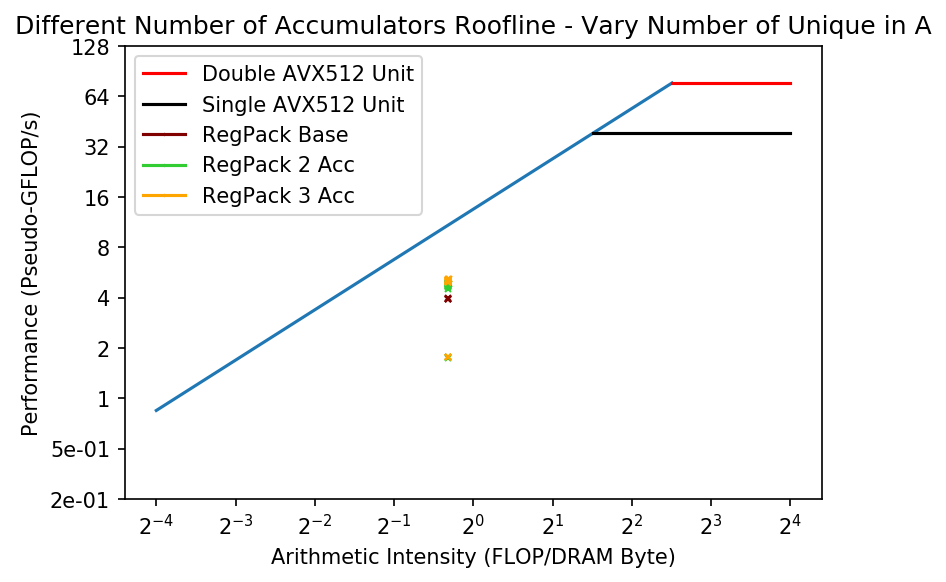

In [50]:
key = 'vary_unique'
mat_names, ref_FLOPs, local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1[key], run_2[key], run_3[key]])
_, _, ln3_FLOPs = calc_GFLOPs(mat_FLOPS, [ln3_run_1[key], ln3_run_2[key], ln3_run_3[key]])
ref_AIs, local_AIs = get_AI(mat_AI_ref, mat_AI_local, mat_names)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='black', label="Single AVX512 Unit")

ax.plot(local_AIs[0], ref_FLOPs[0], marker='x', color='maroon', ms=1, label="RegPack Base")
for i, mat_name in enumerate(mat_names[:4]):
    ax.plot(local_AIs[i], ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(local_AIs[0], local_FLOPs[0], marker='x', color='limegreen', ms=1, label="RegPack 2 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], local_FLOPs[i], marker='x', color='limegreen', ms=3)
ax.plot(local_AIs[0], ln3_FLOPs[0], marker='x', color='orange', ms=1, label="RegPack 3 Acc")
for i, mat_name in enumerate(mat_names):
    ax.plot(local_AIs[i], ln3_FLOPs[i], marker='x', color='orange', ms=3)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
ax.set_title('Different Number of Accumulators Roofline - Vary Number of Unique in A')
plt.legend()
plt.savefig("./../../../plots/regpack_ln2/synth/roofline/vary_unique.pdf")
plt.show()